#### In this notebook I will explore the topic of Time-Series Forecasting as part a Project Work for my University, and eventually make submission(s) for the competition described below.



# Contents
1. Defining the problem and goal
2. Importing the Data
3. EDA: Exploratory Data Analysis
4. Modelling time dependency: 

    4.1  Trends
    
    4.2  Seasonality
    
    4.3  Residual Analysis
    
    4.4  Holiday Features
    
5. Modelling serial dependency:

    5.1 Modelling Serial Dependecy on School and Office Supply
    
    5.2 Leading Indicator Feature
    
6. Hybrid model
7. Forecasting using Machine Learning

# 1. Defining the problem and the goal 

The ***problem*** is a time-series prediction problem presented as a competition, more specifically the [Store Sales Time-Series Forecasting Competition](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview/description) ,

where the ***goal*** is to use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer. Essencially, to use machine learning to predict grocery sales.


### [- Dataset description](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)
The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

#### Training data: train.csv

* The training data, comprising time series of features **store_nbr**, **family**, and **onpromotion** as well as the target **sales**.
* **store_nbr** identifies the store at which the products are sold.
* **family** identifies the type of product sold.
* **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
* **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.


#### Test data: test.csv

* The test data, having the same features as the training data. You will predict the target **sales** for the dates in this file. 
* The dates in the test data are for the 15 days after the last date in the training data.


#### Submission file: sample_submission.csv
A sample submission file in the correct format.

#### Additional information
#### 1. Store metadata: stores.csv
  * Store metadata, including **city**, **state**, **type**, and **cluster**.
  * **cluster** is a grouping of similar stores.

#### 2. Daily oil price: oil.csv 
Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

#### 3. Holidays and Events, with metadata: holidays_events.csv
  * NOTE: Pay special attention to the **transferred** column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
  * Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).


#### Additional Notes
* Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
* A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

### [- Evaluation](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview/evaluation)
The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as:
$[\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}]$
where:

𝑛 is the total number of instances,  
𝑦̂ 𝑖 is the predicted value of the target for instance (i),  
𝑦𝑖 is the actual value of the target for instance (i), and,  
log is the natural logarithm.

# 2. Importing the data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import datetime
from pathlib import Path
#from learntools.time_series.style import *  # plot style settings
#from learntools.time_series.utils import (seasonal_plot,
#                                          plot_periodogram,
#                                          make_lags,
#                                          make_leads,
#                                          plot_lags,
#                                          make_multistep_target,
#                                          plot_multistep)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder

# Model 1 (trend)
from sklearn.linear_model import LinearRegression

# Model 2
from sklearn.neighbors import KNeighborsRegressor

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
## Utils Plot tools
## from learntools.time_series


def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette(
        "husl",
        n_colors=X[period].nunique(),
    )
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


# From Lesson 4
def lagplot(x, y=None, shift=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(shift)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    title = f"Lag {shift}" if shift > 0 else f"Lead {shift}"
    ax.set(title=f"Lag {shift}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x,
              y=None,
              lags=6,
              leads=None,
              nrows=1,
              lagplot_kwargs={},
              **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    orig = leads is not None
    leads = leads or 0
    kwargs.setdefault('ncols', math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, shift=k + 1, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


# def make_lag_features(y, lags):
#     name = 'lag' if lags > 0 else 'lead'
#     steps = range(1, lags + 1) if lags > 0 else range(-1, lags - 1, -1)
#     return pd.concat(
#         [y.shift(i, freq='infer') for i in steps],
#         axis=1,
#         join='outer',
#         keys=[f'{y.name}_{name}_{i if lags > 0 else -i}' for i in steps],
#     )

# From Lesson 5


class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
        self.stack_cols = None

    def fit(self, X_1, X_2, y, stack_cols=None):
        # Train model_1
        self.model_1.fit(X_1, y)

        # Make predictions
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns=y.columns,
        )
        # Compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack(stack_cols).squeeze()  # wide to long

        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        self.stack_cols = stack_cols

    def predict(self, X_1, X_2):
        # Predict with model_1
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns=self.y_columns,
        )
        y_pred = y_pred.stack(self.stack_cols).squeeze()  # wide to long

        # Add model_2 predictions to model_1 predictions
        y_pred += self.model_2.predict(X_2)
        return y_pred.unstack(self.stack_cols)


# From Lesson 6
def make_lags(ts, lags, lead_time=1, name='y'):
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


def make_leads(ts, leads, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(leads))},
        axis=1)


def make_multistep_target(ts, steps, reverse=False):
    shifts = reversed(range(steps)) if reverse else range(steps)
    return pd.concat({f'y_step_{i + 1}': ts.shift(-i) for i in shifts}, axis=1)


def create_multistep_example(n, steps, lags, lead_time=1):
    ts = pd.Series(
        np.arange(n),
        index=pd.period_range(start='2010', freq='A', periods=n, name='Year'),
        dtype=pd.Int8Dtype,
    )
    X = make_lags(ts, lags, lead_time)
    y = make_multistep_target(ts, steps, reverse=True)
    data = pd.concat({'Targets': y, 'Features': X}, axis=1)
    data = data.style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                     .set_properties(['Features'], **{'background-color': 'Lavender'})
    return data


def load_multistep_data():
    df1 = create_multistep_example(10, steps=1, lags=3, lead_time=1)
    df2 = create_multistep_example(10, steps=3, lags=4, lead_time=2)
    df3 = create_multistep_example(10, steps=3, lags=4, lead_time=1)
    return [df1, df2, df3]


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

import warnings

import matplotlib.pyplot as plt
from IPython import get_ipython

warnings.simplefilter("ignore")

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

get_ipython().config.InlineBackend.figure_format = 'retina'

In [3]:
input_dir = Path('../input/store-sales-time-series-forecasting')

# Training data: train.csv

# For the first part of the analysis (time-dependence), we are going to
# use a restricted training data, using information about the store number,
# family, date and the sales; we will use the rest of the training data
# as we expand the analysis.
store_sales = pd.read_csv(
    input_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

# Holidays and Events, with metadata
holidays_events = pd.read_csv(
    input_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

# Test data: test.csv
df_test = pd.read_csv(
    input_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# 3. EDA: Exploratory Data Analysis

Let's take a look at the training data.

In [4]:
print("Training Data", "\n" + "-" * 14 + "\n", store_sales)
print("\n")
print("Test Data", "\n" + "-" * 10 + "\n", df_test)
print("\n")
print("Holidays events Data", "\n" + "-" * 14 + "\n", holidays_events)

Training Data 
--------------
                                      sales
store_nbr family     date                 
1         AUTOMOTIVE 2013-01-01   0.000000
                     2013-01-02   2.000000
                     2013-01-03   3.000000
                     2013-01-04   3.000000
                     2013-01-05   5.000000
...                                    ...
9         SEAFOOD    2017-08-11  23.830999
                     2017-08-12  16.859001
                     2017-08-13  20.000000
                     2017-08-14  17.000000
                     2017-08-15  16.000000

[3000888 rows x 1 columns]


Test Data 
----------
                                       id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  

In [5]:
store_sales #train.csv

sales
store_nbr family     date                 
1         AUTOMOTIVE 2013-01-01   0.000000
                     2013-01-02   2.000000
                     2013-01-03   3.000000
                     2013-01-04   3.000000
                     2013-01-05   5.000000
...                                    ...
9         SEAFOOD    2017-08-11  23.830999
                     2017-08-12  16.859001
                     2017-08-13  20.000000
                     2017-08-14  17.000000
                     2017-08-15  16.000000

[3000888 rows x 1 columns]

In [6]:
df_test

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0
...                                  ...          ...
9         SEAFOOD    2017-08-27  3022271            0
                     2017-08-28  3024053            0
                     2017-08-29  3025835            0
                     2017-08-30  3027617            0
                     2017-08-31  3029399            0

[28512 rows x 2 columns]

In [7]:
holidays_events

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


## 3.1 Indexes
### Dates

In [8]:
print("Total duration of data:")
print(f"    Training data: {store_sales.index.get_level_values(2).min()} --> {store_sales.index.get_level_values(2).max()}")
print(f"    Test data: {df_test.index.get_level_values(2).min()} --> {df_test.index.get_level_values(2).max()}")

Total duration of data:
    Training data: 2013-01-01 --> 2017-08-15
    Test data: 2017-08-16 --> 2017-08-31


### Family

In [9]:
print(f"Total number of families: {len(store_sales.index.unique(level=1))}")

print(f"First 5 families (in alphabetical order): {[x.capitalize() for x in store_sales.index.unique(level=1)[:5]]}")

print(f"Last 5 families (in alphabetical order): {[x.capitalize() for x in store_sales.index.unique(level=1)[-5:]]}")

print(f"List of families: {[x.capitalize() for x in store_sales.index.unique(level=1)]}")

Total number of families: 33
First 5 families (in alphabetical order): ['Automotive', 'Baby care', 'Beauty', 'Beverages', 'Books']
Last 5 families (in alphabetical order): ['Poultry', 'Prepared foods', 'Produce', 'School and office supplies', 'Seafood']
List of families: ['Automotive', 'Baby care', 'Beauty', 'Beverages', 'Books', 'Bread/bakery', 'Celebration', 'Cleaning', 'Dairy', 'Deli', 'Eggs', 'Frozen foods', 'Grocery i', 'Grocery ii', 'Hardware', 'Home and kitchen i', 'Home and kitchen ii', 'Home appliances', 'Home care', 'Ladieswear', 'Lawn and garden', 'Lingerie', 'Liquor,wine,beer', 'Magazines', 'Meats', 'Personal care', 'Pet supplies', 'Players and electronics', 'Poultry', 'Prepared foods', 'Produce', 'School and office supplies', 'Seafood']


### Stores

In [10]:
print(f"Total number of stores: {len(store_sales.index.unique(level=0))}")

Total number of stores: 54


# 4. Modelling time dependency
Time dependece is one of the two essencial component of a time-series. 
Specifically, a series is time dependent if its values can be predicted from the time they occured.

In this part we will model the features of time series that are time dependent (trends and seasonality), and as such the time series based on those feature require linear algorithm (e.g. Linear Regression) to make a forecasting.

## 4.1 Trends
A trend represents a persistent, long-term change in the mean of the series. It is the slowest-moving part of a series, the part representing the largest time scale of importance.

In [11]:
avg_sales = store_sales.groupby('date').mean()['sales']
avg_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

### Moving average plot

In [12]:
# moving average plot to estimate the trend

trend = avg_sales.rolling(
    window=365, #smooth over short-term changes within the year
    center=True,
    min_periods=183,
).mean()

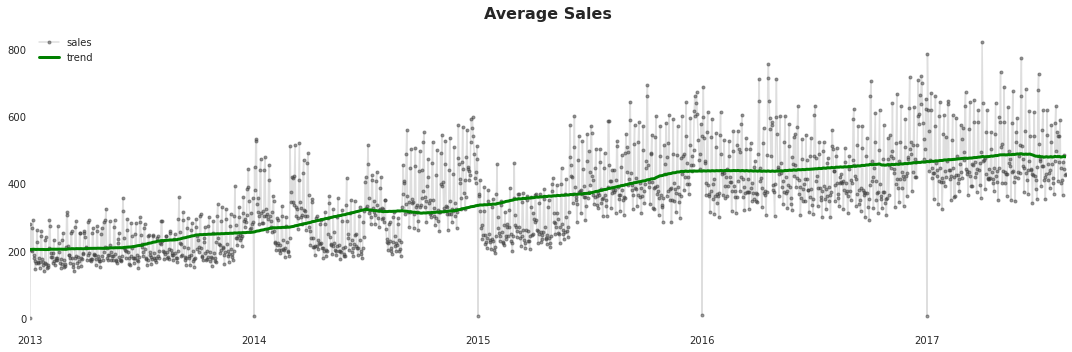

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
avg_sales.plot(**plot_params, alpha=0.5, title="Average Sales", ax=ax)
trend.plot(linewidth=3, label='trend', color='g', ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(False)
ax.legend();
ax.set_xlabel("")
plt.savefig('avg_sales_trend.png', dpi=300)

### Time-series based on Trends

In [14]:
# the target

y = avg_sales.copy()
y.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

and evaluate perfomance on the validation set.

#### Polynomial order 1

In [15]:
dp = DeterministicProcess(
    index=y.index,          # dates from the training data
    constant=True,          # dummy feature for the bias (y_intercept)
    order=1,                # the time dummy (trend): linear trend
    drop=True,              # drop terms if necessary to avoid collinearity
)

X = dp.in_sample()
X.head()

,const,trend
date,,
2013-01-01,1.0,1.0
2013-01-02,1.0,2.0
2013-01-03,1.0,3.0
2013-01-04,1.0,4.0
2013-01-05,1.0,5.0


The validation set is choosen to have size 15 such as the total duration of the test set (15 days).

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

For conguence with the test set, we use the **Root Mean Squared Logarithmic Error** as the evaluation metric (described above in the problem definition) also for the validation set.

Training RMSLE: 0.32472
Validation RMSLE: 0.18144


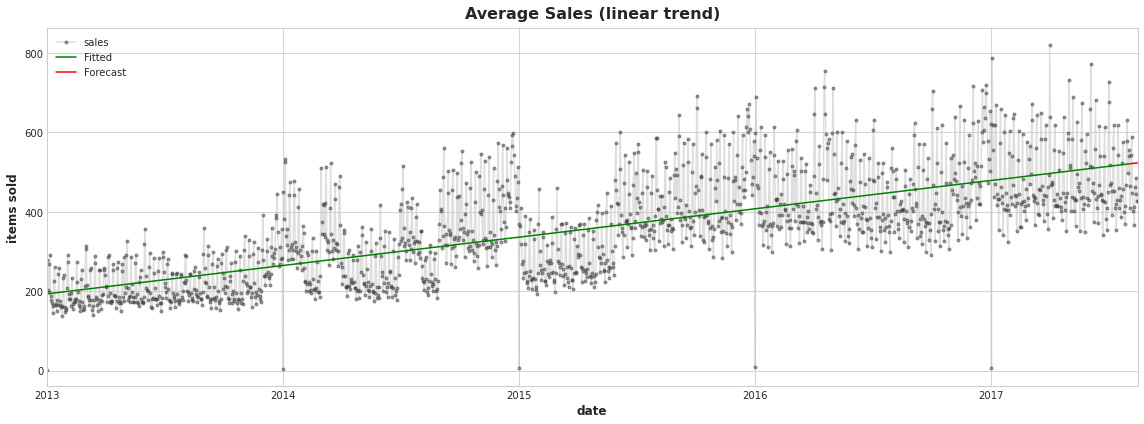

In [17]:
rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

fig, ax = plt.subplots(figsize=(16,6))
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales (linear trend)", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='g')
ax = y_pred.plot(ax=ax, label="Forecast", color='r')
ax.legend();

#### Polynomial order 3

In [18]:
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend): cubic trend
    drop=True,           # drop terms if necessary to avoid collinearity
)

X = dp.in_sample()
X.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2013-01-01,1.0,1.0,1.0,1.0
2013-01-02,1.0,2.0,4.0,8.0
2013-01-03,1.0,3.0,9.0,27.0
2013-01-04,1.0,4.0,16.0,64.0
2013-01-05,1.0,5.0,25.0,125.0


In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

Training RMSLE: 0.32328
Validation RMSLE: 0.14174


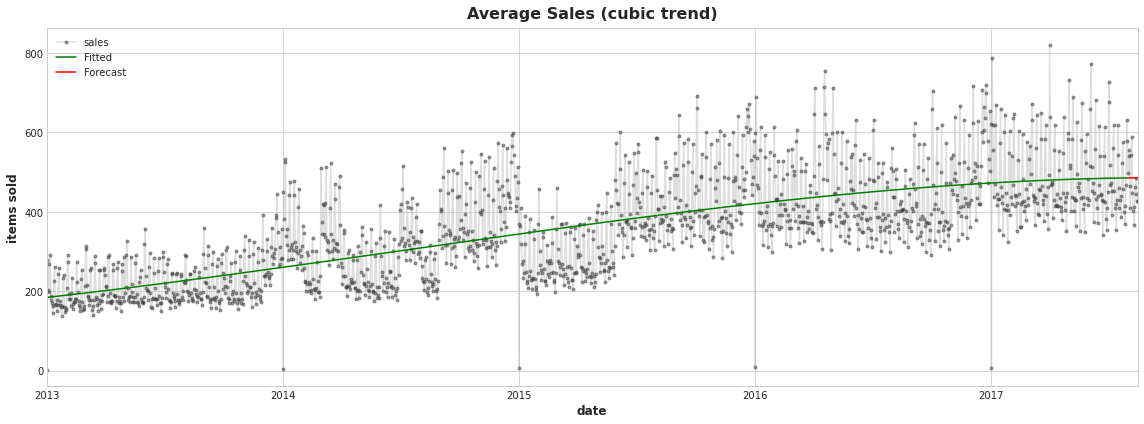

In [20]:
rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

fig, ax = plt.subplots(figsize=(16,6))
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales (cubic trend)", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='g')
ax = y_pred.plot(ax=ax, label="Forecast", color='r')
ax.legend();

Interpretation: we see that the linear and cubic polynomial perform similarly on the training data but the cubic polynomial generalizes better on the validation set. For this reason from now on we will consider the cubic trend.

#### Trend for each family
Analysing the structure of the store sale data it is obvious that each family has their own trend. Let's consider the trend as combination of the trend of each family. This is possibile by redefining the target data as date and family.

In [21]:
y = store_sales.unstack(['store_nbr', 'family'])  # the target
y.head()

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0   470.652008   
2013-01-03        3.0       0.0    0.0     919.0   0.0   310.654999   
2013-01-04        3.0       0.0    3.0     953.0   0.0   198.365997   
2013-01-05        5.0       0.0    3.0    1160.0   0.0   301.057007   

                                                    ...                        \
store_nbr                                           ...         9               
family     CELEBRATION CLEANING  DAIRY        DELI  ... MAGAZINES       MEATS   
date                                                ...                         
2013-01-01         0.0      0.0    0.0    0.000000  ...       0.0    0.000000   
2013-01-02         0.0   1060.0  579.0  164.069000  ...       0.0  374.531006   
2013-01-03         0.0    836.0  453.0  151.582001  ...       0.0  400.863007   
2013-01-04         0.0    827.0  460.0  131.410995  ...       0.0  310.877991   
2013-01-05         0.0    811.0  464.0  118.612999  ...       0.0  447.684998   

                                                                           \
store_nbr                                                                   
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS     POULTRY   
date                                                                        
2013-01-01           0.0          0.0                     0.0    0.000000   
2013-01-02         482.0          0.0                     0.0  651.291992   
2013-01-03         372.0          0.0                     0.0  509.496002   
2013-01-04         324.0          0.0                     0.0  332.671997   
2013-01-05         461.0          0.0                     0.0  510.919006   

                                                                         
store_nbr                                                                
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                     
2013-01-01            0.0     0.0                        0.0   0.000000  
2013-01-02           83.0     0.0                        0.0  29.214001  
2013-01-03           66.0     0.0                        0.0  25.000000  
2013-01-04           57.0     0.0                        0.0  11.000000  
2013-01-05           84.0     0.0                        0.0  28.361000  

[5 rows x 1782 columns]

In [22]:
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend): cubic trend
    drop=True,           # drop terms if necessary to avoid collinearity
)

X = dp.in_sample()
X.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2013-01-01,1.0,1.0,1.0,1.0
2013-01-02,1.0,2.0,4.0,8.0
2013-01-03,1.0,3.0,9.0,27.0
2013-01-04,1.0,4.0,16.0,64.0
2013-01-05,1.0,5.0,25.0,125.0


In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y_train.columns).clip(0.0)
y_pred = pd.DataFrame(model.predict(X_valid), index=X_valid.index, columns=y_valid.columns).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

y_pred.head()

Training RMSLE: 1.08942
Validation RMSLE: 0.59417


sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-01   3.989250       0.0  3.531821  2196.628603  0.716912   343.640481   
2017-08-02   3.987273       0.0  3.534058  2196.550189  0.718472   343.374526   
2017-08-03   3.985285       0.0  3.536296  2196.469286  0.720033   343.107744   
2017-08-04   3.983288       0.0  3.538537  2196.385892  0.721597   342.840136   
2017-08-05   3.981282       0.0  3.540779  2196.300004  0.723162   342.571700   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-08-01   14.867376  652.084491  723.399901  125.146642  ...  3.572239   
2017-08-02   14.857873  651.978731  723.315812  125.079406  ...  3.567129   
2017-08-03   14.848331  651.872595  723.231415  125.011949  ...  3.561989   
2017-08-04   14.838750  651.766082  723.146710  124.944271  ...  3.556819   
2017-08-05   14.829128  651.659192  723.061697  124.876371  ...  3.551620   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-08-01  400.943405    450.827401     8.332957               11.246038   
2017-08-02  400.976549    450.483202     8.338341               11.239880   
2017-08-03  401.009700    450.137935     8.343720               11.233688   
2017-08-04  401.042858    449.791600     8.349094               11.227461   
2017-08-05  401.076023    449.444195     8.354462               11.221199   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-08-01  469.952945     130.385421  1632.064882                   2.883387   
2017-08-02  470.156275     130.457848  1631.080944                   2.857556   
2017-08-03  470.360760     130.530316  1630.091322                   2.831655   
2017-08-04  470.566403     130.602826  1629.096009                   2.805684   
2017-08-05  470.773206     130.675376  1628.094999                   2.779641   

                       
store_nbr              
family        SEAFOOD  
date                   
2017-08-01  16.740531  
2017-08-02  16.732058  
2017-08-03  16.723550  
2017-08-04  16.715008  
2017-08-05  16.706430  

[5 rows x 1782 columns]

### ➜ Forecasting based on target (first submission)

In [24]:
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

X_test.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2017-08-16,1.0,1685.0,2839225.0,4.784094e+09
2017-08-17,1.0,1686.0,2842596.0,4.792617e+09
2017-08-18,1.0,1687.0,2845969.0,4.801150e+09
2017-08-19,1.0,1688.0,2849344.0,4.809693e+09
2017-08-20,1.0,1689.0,2852721.0,4.818246e+09


In [25]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission_trend.csv', index=False)

y_submit.head()

id        sales
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888     3.958569
                     BABY CARE   3000889     0.000000
                     BEAUTY      3000890     3.565596
                     BEVERAGES   3000891  2195.189935
                     BOOKS       3000892     0.740510

> ## Kaggle Score: 0.63608

## 4.2 Seasonality
While trends represent long-term changes in the mean of the series, [seasonality](https://www.kaggle.com/code/ryanholbrook/seasonality) represents **regular, periodic changes in the mean of the series** caused by weekly, monthly, seasonal or yearly patterns of social behaviour. In this context a season can mean a week, month, year or an actual 'season' (e.g., Vivaldi's "The Four Seasons"). However, depending on the number of observations in a season, we might use **two distinct features** to model seasonality:

* [Seasonal indicators](https://www.kaggle.com/code/ryanholbrook/seasonality#Seasonal-Plots-and-Seasonal-Indicators): For a season with few observations (eg, a weekly season of daily observations) seasonal differences in the level of the time series (eg, difference between daily observations in a week) can be represented through binary features, or more specifically, one-hot-encoded categorical features. These features are called **seasonal indicators** and can be represented through seasonal plots.
* [Fourier features](https://www.kaggle.com/code/ryanholbrook/seasonality#Fourier-Features-and-the-Periodogram): Seasonal indicators create a feature for every unit of the period of the season. Hence, they have the tendency to blow up for long seasons, e.g., daily observations over a year. For such cases, we use **Fourier features**, pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest, to capture the overall shape of the seasonal curve with just a few features. We can choose these features using a **periodogram** which tells us the strength of the frequencies in a time series.

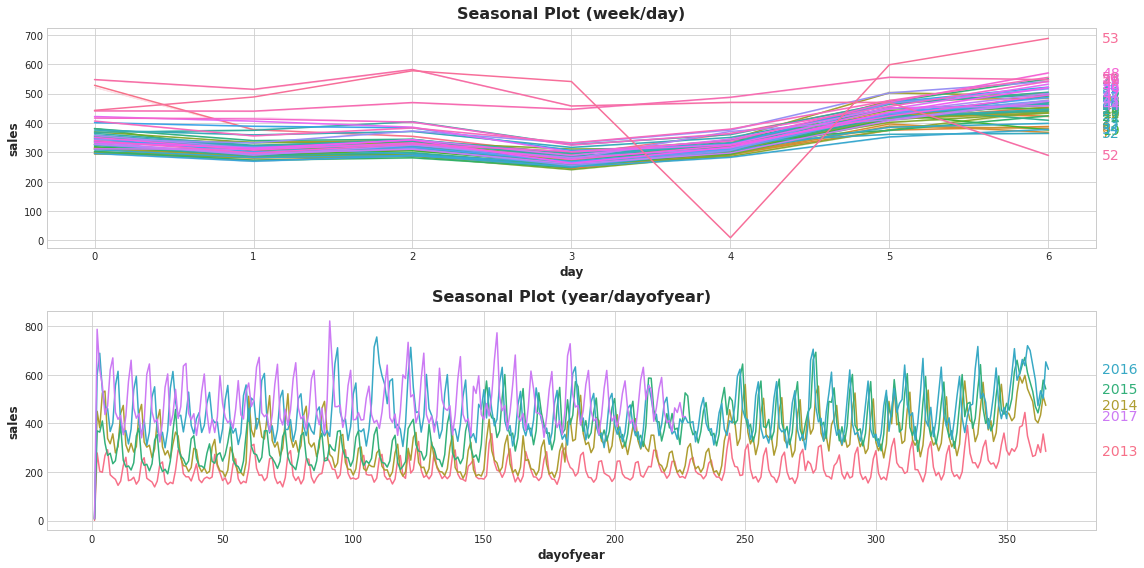

In [26]:
X = avg_sales.to_frame()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(16, 8))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);
plt.savefig('seasonal plot all.png', dpi=300)

> #### Interpretation: The two plot show an evident increase of sales during week-ends.

More specifically
* The *weekly seasonal plot* shows for each weeks within a year (1-53) the number of sales in days from Monday (0) to Sunday (6).
On week 53, the last of the year, on Friday (4) there are very few sales. This is jusified by the fact that most years have 52 week, in the period of the traning data from 2013 to 2017 there is only one 53th week. On the graph, that friday corresponds to new year's eve, which usually has few sales, and the line representing the 53th week show exactly the sales of that week from 2015-12-28 to 2016-01-03.
This analysis shows that it is important to consider the holidays in the modelling process.
* In fact in the *yearly seasonal plot* it is shown that sales are low on every 1st of Jannuary. And also that the sales changes with a similar frequency, but they don't match with the exact day of year. It is worth noticing that the end of the year there is an increase of sales, probabily due to holidays.



In [27]:
# Show the sales of the 53th week
X[X['week']==53]

,sales,day,week,dayofyear,year
date,,,,,
2015-12-28,443.145294,0,53,362,2015
2015-12-29,488.643127,1,53,363,2015
2015-12-30,578.026794,2,53,364,2015
2015-12-31,541.325195,3,53,365,2015
2016-01-01,9.221882,4,53,1,2016
2016-01-02,598.584412,5,53,2,2016
2016-01-03,688.403870,6,53,3,2016


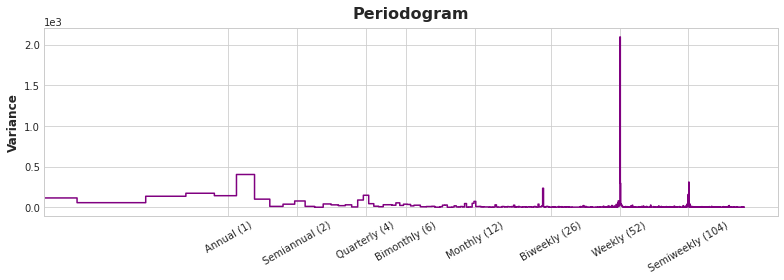

In [28]:
plot_periodogram(avg_sales);

#### Interpretation:  as expected, there is a strong weekly seasonality. The periodogram shows also a week annually seasonality, to be modelled with Fourier features.

>   **Choosing Fourier Features:**
How many Fourier pairs should we actually include in our feature set? From right to left, the periodogram falls off between Bimonthly (6) and Monthly (12), so let's use 10 Fourier pairs.

### Adding Seasonal features: 
While creating the cubic trend, let's add the weekly seasonality (seasonal indicators) by setting seasonal parameter to True and adding the annual seasonality by adding Fourier features as additional terms.

In [29]:
y = store_sales.unstack(['store_nbr', 'family'])#.loc["2017"]

fourier = CalendarFourier(freq='A', order=10) ## 2 pairs of sine/cosine curves to model monthly/biweekly seasonality
dp = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # linear trend
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y_train.columns).clip(0.0)
y_pred = pd.DataFrame(model.predict(X_valid), index=X_valid.index, columns=y_valid.columns).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

y_pred.head()

Training RMSLE: 1.16594
Validation RMSLE: 0.58326


sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-01   4.953936       0.0  3.306737  2246.974965  0.373197   369.529873   
2017-08-02   4.882141       0.0  3.254167  2225.239544  0.345177   386.690007   
2017-08-03   5.170742       0.0  3.314313  2263.517438  0.308487   403.668162   
2017-08-04   5.383187       0.0  3.449976  2351.753812  0.288438   440.781395   
2017-08-05   5.079181       0.0  3.372870  2372.711992  0.289279   431.397997   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-08-01   15.482020  588.287452  724.769896  129.188426  ...  3.444759   
2017-08-02   16.517681  602.358475  733.442187  131.027604  ...  3.217956   
2017-08-03   24.454581  616.573043  767.662838  128.811751  ...  3.321006   
2017-08-04   19.391537  731.519418  811.453409  148.002710  ...  3.170995   
2017-08-05   19.581998  709.189995  806.593668  144.289980  ...  3.424355   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-08-01  401.661909    553.694875     7.912402               14.512965   
2017-08-02  411.680739    550.335802     7.583306               13.772073   
2017-08-03  417.337961    510.948708     7.288483               12.751502   
2017-08-04  397.039117    455.111713     7.128756               12.305642   
2017-08-05  376.505627    461.107963     7.706463               13.241429   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-08-01  514.387936     117.046197  2132.169051                   9.488913   
2017-08-02  518.950483     117.539015  2118.390704                   8.844281   
2017-08-03  455.636033     110.845834  1876.517663                   6.809827   
2017-08-04  412.464207     100.981894  1806.593555                   5.714559   
2017-08-05  438.928257     105.727597  1779.248856                   4.407783   

                       
store_nbr              
family        SEAFOOD  
date                   
2017-08-01  15.174452  
2017-08-02  15.186541  
2017-08-03  13.747129  
2017-08-04  11.124456  
2017-08-05  12.535714  

[5 rows x 1782 columns]

### ➜ Forecasting based on Trends and Seasonality (second submission)

In [31]:
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

X_test.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1.0,1685.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.693281,-0.720667,...,-0.993257,-0.115935,0.796183,-0.605056,-0.154309,0.988023,-0.573772,-0.819015,0.981306,0.192452
2017-08-17,1.0,1686.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.705584,-0.708627,...,-0.999917,-0.012910,0.717677,-0.696376,-0.017213,0.999852,-0.693281,-0.720667,0.999769,0.021516
2017-08-18,1.0,1687.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.717677,-0.696376,...,-0.995919,0.090252,0.628763,-0.777597,0.120208,0.992749,-0.796183,-0.605056,0.988678,-0.150055
2017-08-19,1.0,1688.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.729558,-0.683919,...,-0.981306,0.192452,0.530730,-0.847541,0.255353,0.966848,-0.880012,-0.474951,0.948362,-0.317191
2017-08-20,1.0,1689.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.741222,-0.671260,...,-0.956235,0.292600,0.425000,-0.905193,0.385663,0.922640,-0.942761,-0.333469,0.880012,-0.474951


In [32]:
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_pred.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission_trend_seasonality.csv', index=False)

y_submit.head()

id        sales
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888     4.299846
                     BABY CARE   3000889     0.000000
                     BEAUTY      3000890     3.182246
                     BEVERAGES   3000891  2159.074062
                     BOOKS       3000892     0.328001

> ## Kaggle Score: 0.62179

### Restricting the period of store sales (train data)
Intuition from the above plots and results: Since the period of the training data is 4.5 years while the period of the test data is 15 days, we can restrict the period of the training data to be considered to make the trend of the past year (2017) generalize to the validation/test data.

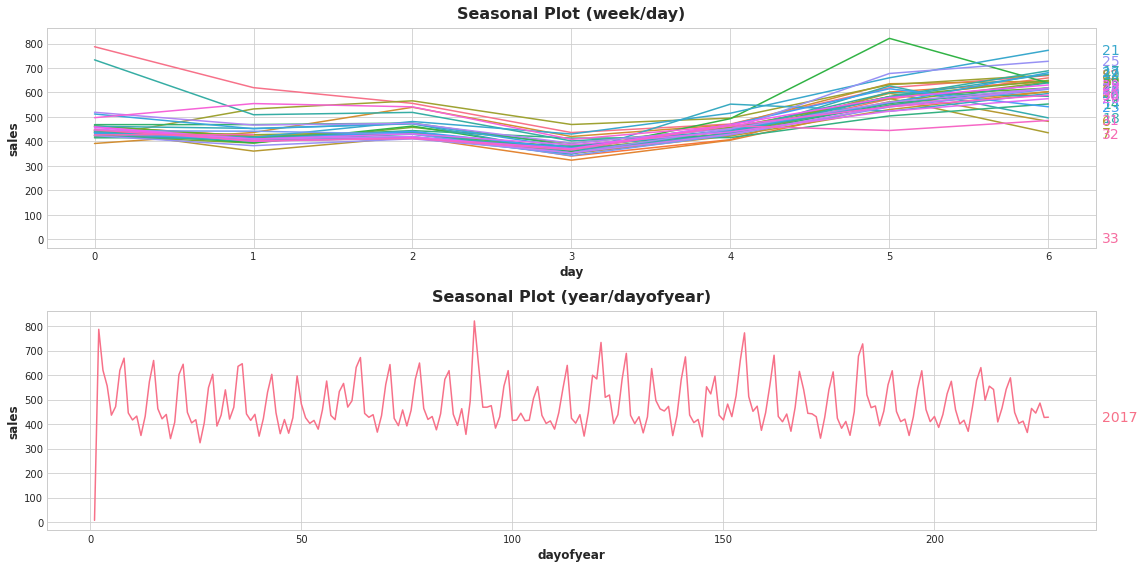

In [33]:
X = avg_sales.loc['2017'].to_frame()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(16, 8))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);

plt.savefig('seasonal plots 2017.png', dpi=300)

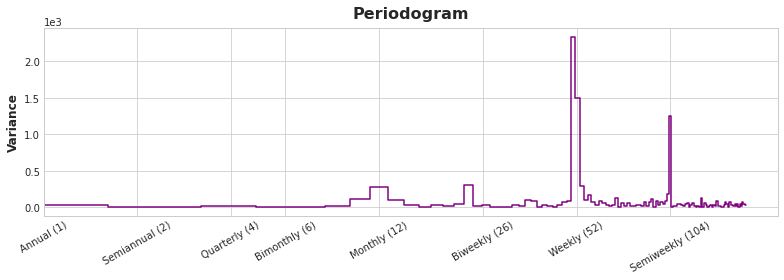

In [34]:
plot_periodogram(avg_sales.loc['2017']);


> #### Interpretation: now the plot of yearly seasonality and periodogram are clearer since we isolated the 2017 line. From the periodogram we conclude that Furier Features to model monthly/biweekly seasonality by using 2 pair of sine/cosine.

In [35]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

fourier_M = CalendarFourier(freq='M', order=4) ## 2 pairs of sine/cosine curves to model monthly/biweekly seasonality
dp = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # linear trend
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier_M],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y_train.columns).clip(0.0)
y_pred = pd.DataFrame(model.predict(X_valid), index=X_valid.index, columns=y_valid.columns).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

y_pred.head()

Training RMSLE: 0.62390
Validation RMSLE: 0.57367


sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-01   5.024247       0.0  3.961651  2244.459247  0.386078   328.939471   
2017-08-02   5.650650       0.0  4.007962  2516.636447  0.532333   414.733731   
2017-08-03   5.837047       0.0  3.110995  2238.215966  0.237725   372.601868   
2017-08-04   7.115996       0.0  2.883839  2529.708792  0.257185   390.066055   
2017-08-05   5.820920       0.0  3.745052  2684.328165  0.022511   414.932839   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-08-01   16.708611  764.296577  707.892565  145.298258  ...  2.676951   
2017-08-02   18.544272  909.880414  869.799854  154.568826  ...  2.515350   
2017-08-03   22.473153  764.980918  743.352956  131.140133  ...  2.013585   
2017-08-04   23.641936  827.092820  826.990356  184.189444  ...  1.972519   
2017-08-05   15.459501  739.807195  832.194912  156.168208  ...  2.549400   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-08-01  410.867911    595.251327     9.305055               12.322685   
2017-08-02  413.416032    588.718899    11.137383               11.659316   
2017-08-03  608.846824    579.525152     9.400345               11.328414   
2017-08-04  370.036334    514.029295     9.666326                8.955014   
2017-08-05  477.268298    760.911738    11.924145               13.997996   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-08-01  465.343467     121.966481  2491.925546                   7.285770   
2017-08-02  472.092037     112.739250  1478.305034                   5.849904   
2017-08-03  464.411599     107.507712  1492.915948                   5.198424   
2017-08-04  586.320915     104.166719  1433.634030                   4.657719   
2017-08-05  642.131141     158.955689  2034.947663                   5.774444   

                       
store_nbr              
family        SEAFOOD  
date                   
2017-08-01  22.008916  
2017-08-02  20.347534  
2017-08-03  19.328054  
2017-08-04  21.600958  
2017-08-05  30.090346  

[5 rows x 1782 columns]

### ➜ Forecasting based on Trends and Seasonality with period restriction of 2017 (third submission)

In [37]:
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_pred.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission_trend_seasonality_2017.csv', index=False)

> ## Kaggle Score: 0.58780

From now on we will consider time-series of 2017 as training set, since it gives better score: meaning that the choice to remove the past year for forecasting task is great. Especially forecasting in the same year of 2017 as our goal.

## 4.3 Residual Analysis: Deseasonalising

At this point, Residual Analysis is made to check the effectiveness of trend and seasonality modelling, but also to check what to model next: serial dependent features.
A residual is what is left behind when we subtract from the data, predictions of our model. At the end of the analysis we are left with just random fluctuations (errors), if we had modelled time and serial dependence properly.

Below we will plot a visual representation of the residual, considering the average sale of the training set. Naturally we could easily visualize deseasonalised residuals of families of products and other features as well.

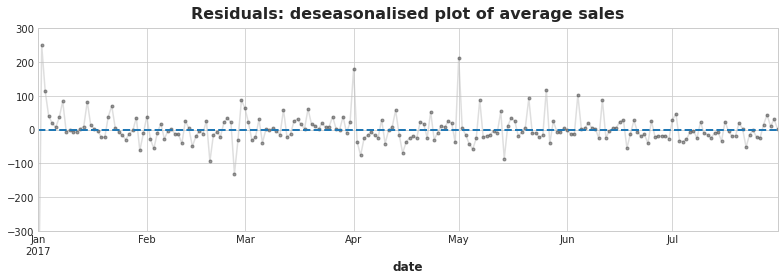

In [38]:
y_train_avg = y_train.stack(['store_nbr', 'family']).groupby('date').mean()['sales']
y_fit_avg = y_fit.stack(['store_nbr', 'family']).groupby('date').mean()['sales']
y_deseason_avg = y_train_avg - y_fit_avg

ax = y_deseason_avg.plot(**plot_params, alpha=0.5, ylim=[-300,300], title='Residuals: deseasonalised plot of average sales')
ax.axhline(y=0, ls='dashed', lw=2)

plt.savefig('deseasonalised average sales.png', dpi=300)

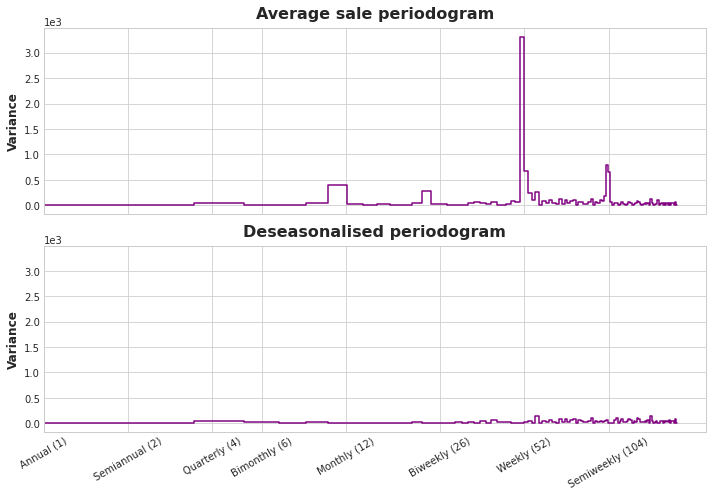

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y_train_avg, ax=ax1)
ax1.set_title("Average sale periodogram")
ax2 = plot_periodogram(y_deseason_avg, ax=ax2);
ax2.set_title("Deseasonalised periodogram");

plt.savefig('Deseasonlised Periodogram.png', dpi=300)

#### Interpretation: on the deseasonalised periodogram, weekly seasonality is lower, even thought it is not absent, probability due to its strong presence on the time series. Also, Bimonthly and Monthly seasonality are reduced to be almost absent.

## 4.4 Holidays Features
As anticipated, holidays need to be considered as a time dependent feature. This is what the dataset looks like:

In [40]:
holidays_events

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


From the whole dataset we consider only:
* national and regional holidays, ignoring local holidays (assuming a local holiday will have minimum impact on the average national sales)
* holidays in 2017 that fall within our training (2017-01-01 : 2017-07-31) + validation (2017-08-01 : 2017-08-15) + test set (2017-08-16 : 2017-08-31)

=> 14 holidays considered

In [41]:
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-31', ['description']] # restricting to the dates in the training set
    .assign(description=lambda x: x.description.cat.remove_unused_categories()) # remove categories which are not used
)

holidays

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


#### Holidays on deseasonalised plot of average sales

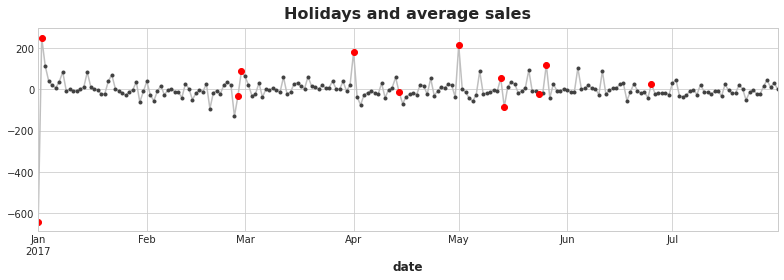

In [42]:
ax = y_deseason_avg.plot(**plot_params)
plt.plot_date(holidays.index[:-2], y_deseason_avg[holidays.index[:-2]], color='r') # the [:-2] is to remove the last 2 dates, 2017-08-10 and 2017-08-11 because they are in the validation set
ax.set_title('Holidays and average sales');
plt.savefig('Holidays and average sales.png', dpi=300)

#### Creating holiday features as seasonal indicators
These features modelling Holidays are created through one-hot-encoding of categorical feature. Then they are joint to the previously modelled feature, and the result is all the time dependent features (X_time).



In [43]:
X_holidays = pd.get_dummies(holidays)
X_holidays.head()

,description_Batalla de Pichincha,description_Carnaval,description_Dia de la Madre,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,
2017-01-01,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-01-02,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-02-27,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-02-28,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-04-01,0,0,0,0,0,0,0,1,0,0,0,0,0


In [44]:
X_time = X.join(X_holidays, on='date').fillna(0.0)
X_time_test = X_test.join(X_holidays, on='date').fillna(0.0)

X_time.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
X_train, X_valid, y_train, y_valid = train_test_split(X_time, y, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y_train.columns).clip(0.0)
y_pred = pd.DataFrame(model.predict(X_valid), index=X_valid.index, columns=y_valid.columns).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

Training RMSLE: 0.51651
Validation RMSLE: 0.56997


### ➜ Forecasting based on Trends, Seasonality and Holidays of 2017 (forth submission)

In [46]:
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

y_submit = pd.DataFrame(model.predict(X_time_test), index=X_time_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission_trend_seasonality_holidays_2017.csv', index=False)
y_submit.head()

id        sales
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888     4.434636
                     BABY CARE   3000889     0.000000
                     BEAUTY      3000890     3.425094
                     BEVERAGES   3000891  2436.376406
                     BOOKS       3000892     0.531519

> ## Kaggle Score: 0.58129

# 5. Modelling Serial Dependency

Serial dependence are behaviours in a time series that are _time-independent_, i.e., they have less to do with a particular time of occurance, but more to do with what happened in the **recent past**; thus bringing a sense of irregularity to the events. An example of serial dependent properties are cycles.

Types of serial dependency:
* **Linear**: where past and present observations are linearly related. Such linear serial dependence can be explored through lag series/plots where **the lag features are chosen by calculating (partial) autocorrelation**. They can also be anticipated through leading indicators, like online trends or promotions. 


* **Non-linear**: where past and present observations can not be related by a simple linear relationship, hence **we can't calculate lag features through (partial) autocorrelations.** Non-linear relationships like these can either be transformed to be linear or else learned by an appropriate algorithm (e.g. XGBoost).

## 5.1 Modelling Serial Dependecy on School and Office Supply 
If we look deeper into the train dataset, we can see that there is a clear evidence that in the family of School and Office Supplies shows a cyclic behaviour in 2017. 

So, let's reload the dataset to include other information for serial dependency modelling. From the reloaded dataset that now includes "onpromotion" features, let's select the family School and Office Supplies.
### Loading Supply Sales

In [47]:
store_sales = pd.read_csv(
    input_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32', ## NEW FEATURE: To be introduced later
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y_supply_sales = supply_sales.loc[:, 'sales'].squeeze()
y_supply_sales

date
2017-01-01     0.000000
2017-01-02     2.925926
2017-01-03     2.018518
2017-01-04     1.722222
2017-01-05     1.425926
                ...    
2017-08-11    65.240738
2017-08-12    67.481483
2017-08-13    68.851852
2017-08-14    52.333332
2017-08-15    46.851852
Freq: D, Name: SCHOOL AND OFFICE SUPPLIES, Length: 227, dtype: float32

### Deseasonalised Sales of "School and Office Supplies"
Obtained by residuals (the considered and complete residual includes both train and valid data) and plotted as such.

In [48]:
y_resid_train = y_train - y_fit 
y_resid_valid = y_valid - y_pred

y_resid = pd.concat([y_resid_train, y_resid_valid])

y_resid_supply_sales = y_resid.stack(['store_nbr', 'family']).groupby(['family', 'date']).mean() .unstack('family').loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES'].loc[:, 'sales'].squeeze().rename('sales_deseason')
y_resid_supply_sales

date
2017-01-01   -9.436896e-15
2017-01-02   -1.257173e-14
2017-01-03   -3.050247e+00
2017-01-04   -2.342834e+00
2017-01-05   -1.975145e+00
                  ...     
2017-08-11    6.142390e+01
2017-08-12    6.211941e+01
2017-08-13    6.135346e+01
2017-08-14    4.721377e+01
2017-08-15    4.197002e+01
Freq: D, Name: sales_deseason, Length: 227, dtype: float64

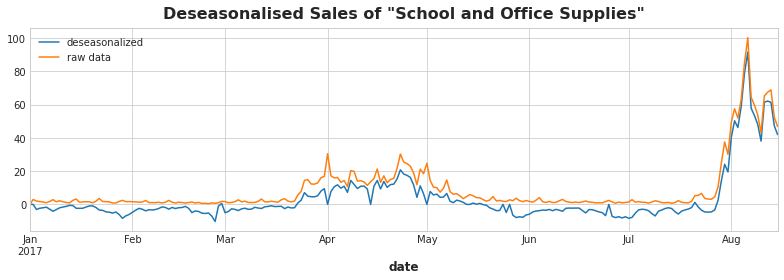

In [49]:
ax = y_resid_supply_sales.plot(label='deseasonalized')
y_supply_sales.plot(ax=ax, label='raw data')
ax.set_title("Deseasonalised Sales of \"School and Office Supplies\"");
ax.legend()
plt.savefig('Deseasonalised Supply Sales.png', dpi=300)

> #### Interpretation: the two curves are close to each other, showing a predominant cyclic behaviour of the raw data of supply sales (target) and the need to model a serial dependence on the residual curve. 

### (Partial) Autocorrelation plots
Usefull tool to identify the number of lag series and to determine the right one(s) to be a lag feature(s).

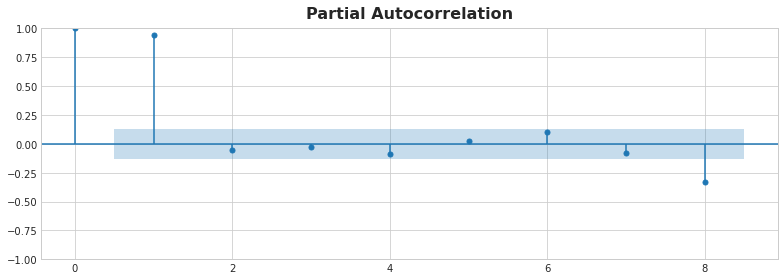

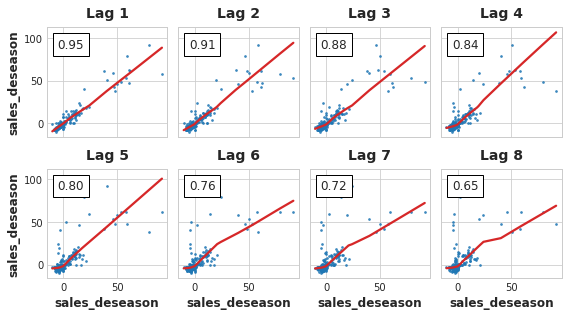

In [50]:
plot_pacf(y_resid_supply_sales, lags=8);
plot_lags(y_resid_supply_sales, lags=8, nrows=2);

> #### Interpretation: From the partial autocorrelation plot and lag plots it looks like the relevant lag to consider is Lag 1.

### Lag Features
From the partial autocorrelation plot (correlogram) it is clear that we need only Lag 1 feature, created below.

In [51]:
X_lags = make_lags(y_resid_supply_sales, lags=1)
X_supply_sales = pd.concat([X_time, X_lags], axis=1).dropna()
print(f"Total features in our combined feature set: {len(X_supply_sales.columns)}")

Total features in our combined feature set: 30


In [52]:
X_lags

,y_lag_1
date,
2017-01-01,NaN
2017-01-02,-9.436896e-15
2017-01-03,-1.257173e-14
2017-01-04,-3.050247e+00
2017-01-05,-2.342834e+00
...,...
2017-08-11,3.804515e+01
2017-08-12,6.142390e+01
2017-08-13,6.211941e+01


Below it is visualize the Lag series placed side by side with the corresponding target residual series.

In [53]:
pd.concat([y_resid_supply_sales,X_lags], axis=1)

,sales_deseason,y_lag_1
date,,
2017-01-01,-9.436896e-15,NaN
2017-01-02,-1.257173e-14,-9.436896e-15
2017-01-03,-3.050247e+00,-1.257173e-14
2017-01-04,-2.342834e+00,-3.050247e+00
2017-01-05,-1.975145e+00,-2.342834e+00
...,...,...
2017-08-11,6.142390e+01,3.804515e+01
2017-08-12,6.211941e+01,6.142390e+01
2017-08-13,6.135346e+01,6.211941e+01


### Training and forecasting on Supply Sales

In [54]:
# Target considering Lag 1 feature and time dependence features
y_supply_sales, X_supply_sales = y_supply_sales.align(X_supply_sales, join='inner')

Training RMSLE: 0.43198
Validation RMSLE: 0.24564


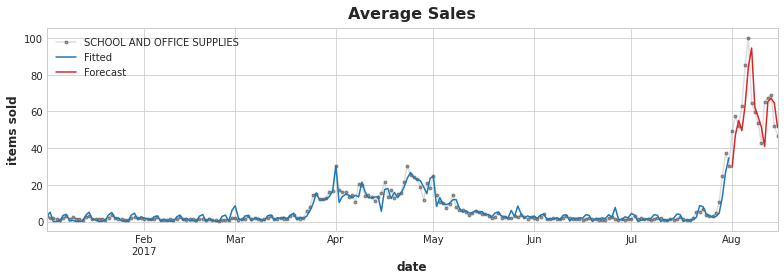

In [55]:
X_train_supply_sales, X_valid_supply_sales, y_train_supply_sales, y_valid_supply_sales = train_test_split(X_supply_sales, y_supply_sales, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train_supply_sales, y_train_supply_sales)
y_fit_supply_sales = pd.Series(model.predict(X_train_supply_sales), index=X_train_supply_sales.index).clip(0.0)
y_pred_supply_sales = pd.Series(model.predict(X_valid_supply_sales), index=X_valid_supply_sales.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train_supply_sales, y_fit_supply_sales) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid_supply_sales, y_pred_supply_sales) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y_supply_sales.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit_supply_sales.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred_supply_sales.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

## 5.2 Leading Indicator Feature
A leading indicator provides "early notice" of changes in the target.

From our dataset we have identified an important leading indicator: **onpromotion**, which is a Series indicating whether a sale for a product (belonging to a family of product) was in promotion.

In [56]:
# onpromotion feature as a boolean variable
X_serial = store_sales.unstack(['store_nbr', 'family']).loc["2017"].loc[:, 'onpromotion']

In [57]:
X_serial.head()

store_nbr           1                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01          0         0      0         0     0            0   
2017-01-02          0         0      0        31     0            2   
2017-01-03          0         0      1        42     0            2   
2017-01-04          0         0      1        54     0            8   
2017-01-05          0         0      2        32     0            7   

store_nbr                                   ...         9                      \
family     CELEBRATION CLEANING DAIRY DELI  ... MAGAZINES MEATS PERSONAL CARE   
date                                        ...                                 
2017-01-01           0        0     0    0  ...         0     0             0   
2017-01-02           0        7    11    3  ...         0     0            13   
2017-01-03           0       18    14    5  ...         0     0            11   
2017-01-04           1       15    32    5  ...         0     0            15   
2017-01-05           0       10    24    1  ...         0    21             8   

store_nbr                                                               \
family     PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY PREPARED FOODS   
date                                                                     
2017-01-01            0                       0       0              0   
2017-01-02            0                       0       2              1   
2017-01-03            0                       0       1              2   
2017-01-04            0                       0       1              8   
2017-01-05            0                       0       1              1   

store_nbr                                              
family     PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                   
2017-01-01       0                          0       0  
2017-01-02       4                          0       0  
2017-01-03     150                          0       0  
2017-01-04       9                          0       0  
2017-01-05       5                          0       1  

[5 rows x 1782 columns]

*X_serial* stands for features from serial dependence modelling, used in the next step to train the non-linear part of the Hybrid model.

# 6. Hybrid Model
Linear regression excels at extrapolating trends, but can't learn interactions. XGBoost excels at learning interactions, but can't extrapolate trends. Let's create a "hybrid" forecasters that combine complementary learning algorithms with the following schema:

​
```
# 1. Train and predict with first model
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)
​
# 2. Train and predict with second model on residuals
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)
​
# 3. Add to get overall predictions
y_pred = y_pred_1 + y_pred_2
```

Note: the number 1 in a variable name is refered to the part of modelling time dependency, while the number 2 is referred to modelling serial dependency.

## 6.1 BoostedHybrid Class
It is just an auxiliary class abstracting the workflow described above. We can pass different kind of models: I choose LinearRegression as model_1, and XGBRegressor as model_2.

In [58]:
class BoostedHybrid:
    
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
        
def fit(self, X_1, X_2, y):
    # Train model_1
    self.model_1.fit(X_1, y)

    # Make predictions
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=y.columns,
    )

    # Compute residuals
    y_resid = y - y_fit
    #y_resid = y_resid.stack().squeeze()

    # Train model_2 on residuals
    self.model_2.fit(X_2, y_resid)
    

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )
    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)
    return y_pred


# Add method to class
BoostedHybrid.predict = predict

In [59]:
# X_1: Time-dependence features

X_1 = X_time # training set time-features
X_1_test = X_time_test # test set time-features

# Splitting between training and validation sets

X_1_train, X_1_valid, y_train, y_valid = train_test_split(X_1, y, test_size=15, shuffle=False)

In [60]:
# X_2: Features for serial dependence
# onpromotion feature as a boolean variable
X_2 = store_sales.unstack(['store_nbr', 'family']).loc["2017"].loc[:, 'onpromotion']

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

# Splitting between training and validation sets
X_2_train, X_2_valid, y_train, y_valid = train_test_split(X_2, y, test_size=15, shuffle=False)

In [61]:
mod_1 = LinearRegression(fit_intercept=False) # for time-dependence
mod_2 = KNeighborsRegressor() # for serial-dependence

model = BoostedHybrid(model_1=mod_1, model_2=mod_2)

model.fit(X_1_train, X_2_train, y_train)
y_fit = model.predict(X_1_train, X_2_train).clip(0.0)
y_pred = model.predict(X_1_valid, X_2_valid).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

Training RMSLE: 0.45829
Validation RMSLE: 0.62112


### ➜ Forecasting with BoostedHybrid model based on linear time-dependent and non-linear serial-dependence (fifth submission)

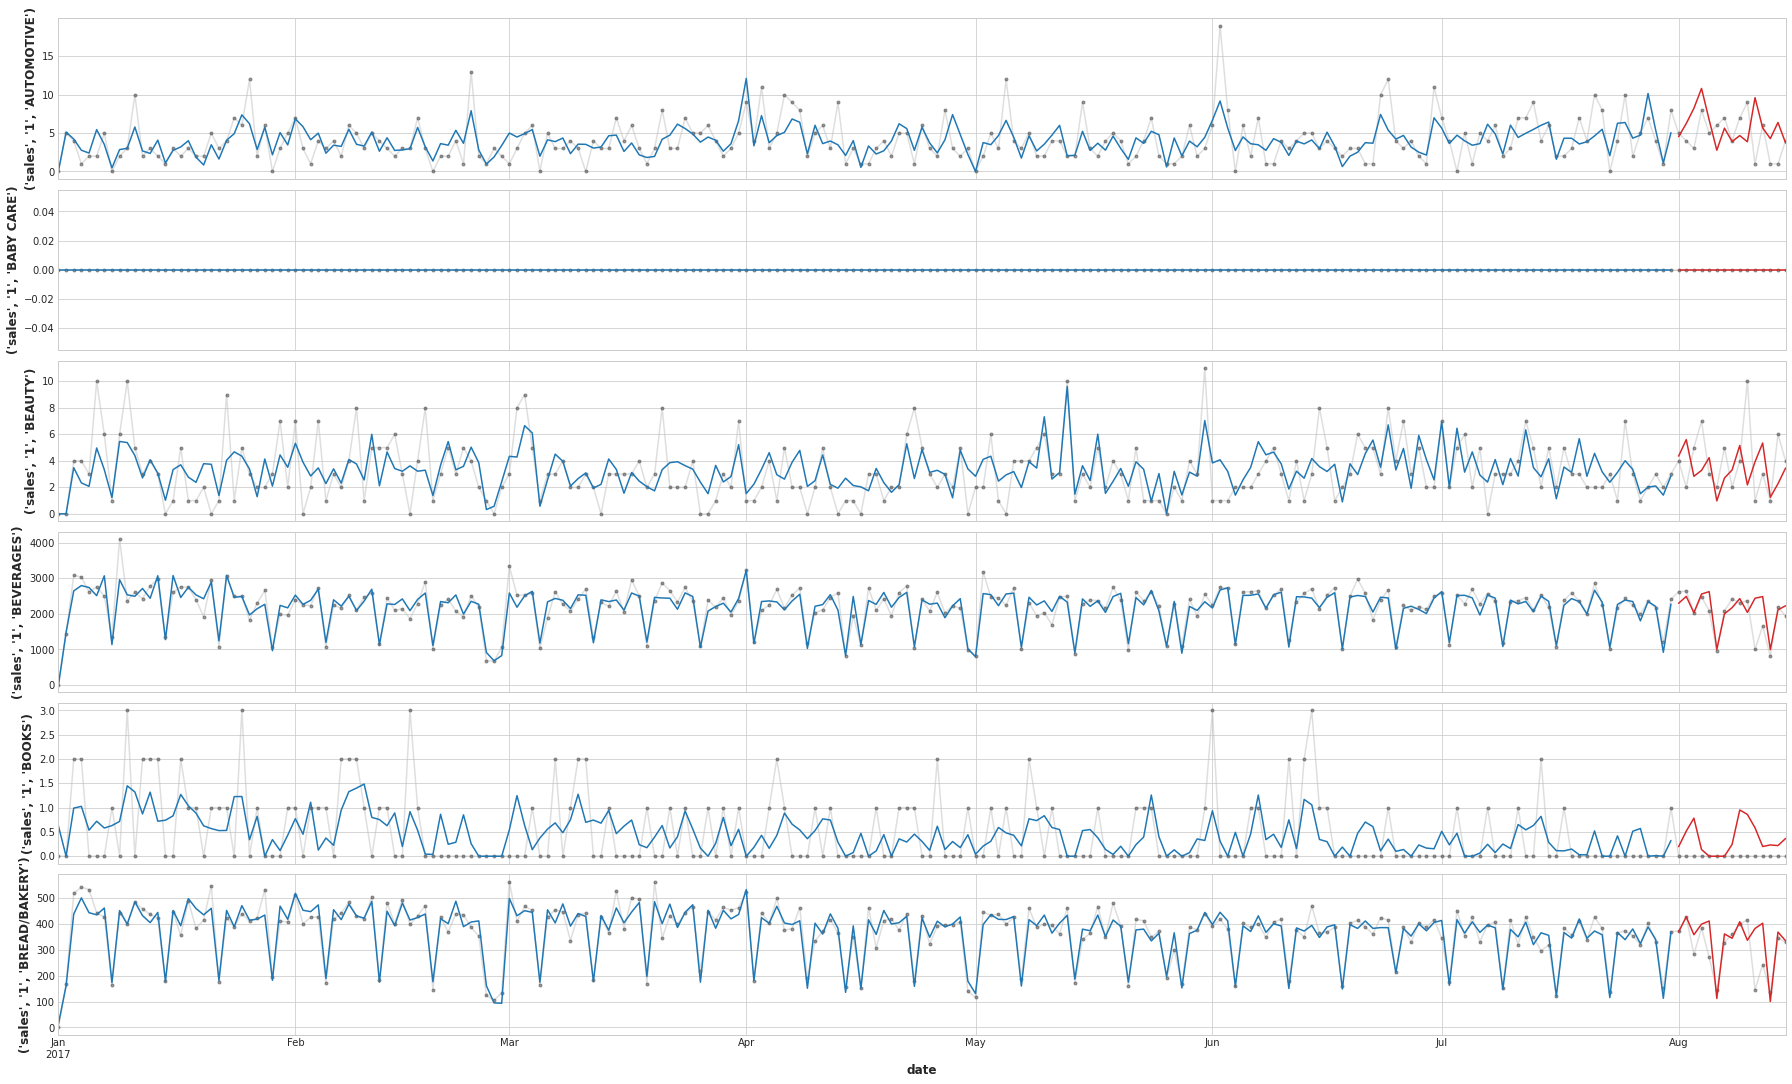

In [62]:
families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(25, 15), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)
    
plt.savefig('forecasting_hybrid.png', dpi=300)

> #### Interpretation: In some product family the model is fitting and predicting well (e.g. BABY CARE, BREAD/BAKERY, BEVERAGES). In others it does not perform as well as for other family of products. This might suggest that it is a good idea to implement more models, one for each product family and train them with their product family sales data, which means identifing different features for each model/family. (e.g. as we did with School and Office Supplies)

In [63]:
# X_1_test: Time-dependence features: test set

# X_2_test: Serial-dependence features: test set
X_2_test = df_test.unstack(['store_nbr', 'family']).loc["2017"].loc[:, 'onpromotion']

# Label encoding for seasonality
X_2_test["day"] = X_2_test.index.day  # values are day of the month

# making submission predictions
y_submit = model.predict(X_1_test, X_2_test).clip(0.0)
y_submit = pd.DataFrame(y_submit.stack(['store_nbr', 'family']))#.rename('sales'))
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission_hybrid.csv', index=False)
y_submit

id        sales
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888     4.549086
                     BABY CARE                   3000889     0.000000
                     BEAUTY                      3000890     4.467870
                     BEVERAGES                   3000891  2384.559095
                     BOOKS                       3000892     0.300994
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395   366.041333
                     PREPARED FOODS              3029396    97.622797
                     PRODUCE                     3029397  1235.178864
                     SCHOOL AND OFFICE SUPPLIES  3029398     5.120332
                     SEAFOOD                     3029399    17.265244

[28512 rows x 2 columns]

> ## Kaggle Score: 0.58717